In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

import shared_utils
from utils import *

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt
import time
from zoneinfo import ZoneInfo

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Notes from RT Kickoff Meeting

* Incorporating trip updates?
* Trip updates can include a measure of delay…
* Relying more on internal processes…
* Trip updates also include overall schedule deviation
* Data can be missing from RT: vehicles without trips, no delay, etc…
* Evan: vehicle positions to infer delay if trip updates available, we’re implicitly deciding that we don’t trust trip updates → trusting the schedule and vehicle positions 100%
* We have trip updates someplace, just needs to be pipelined…
* In theory, update frequency should keep positions and updates close?
* Some feeds omit past events once a bus passes stop, or even future events)
* Data quality:
    * Every 20 seconds, look at next arrival from trip updates…
    * Exploratory analysis? Quicker to use+trust trip updates…


* Analysis timespan
* Confirming agency counts

#### Action items

* Work towards loading trip updates into warehouse
* Look into why there are fewer RT agencies in warehouse (~16) compared to agencies.yml (~30)
* Initial work on an algorithm to interpolate vehicle positions
* Assess how different various feeds’ implementations of trip updates are


In [2]:
## set system time

os.environ['TZ'] = 'America/Los_Angeles'
time.tzset()
time.tzname

('PST', 'PDT')

In [3]:
lbt_itp_id = 170

In [4]:
# %%sql -o lbt_positions

# # get all vehicle positions on selected dates, for the feed with itp id 170, and url number 0
# SELECT *
# FROM `cal-itp-data-infra.gtfs_rt.vehicle_positions`
# WHERE _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-01_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-02_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-03_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-04_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-05_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-06_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-07_170_0.parquet"
# ORDER BY header_timestamp

In [5]:
# lbt_positions.to_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

In [6]:
lbt_positions = pd.read_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

In [7]:
def convert_ts(ts):    
    pacific_dt = dt.datetime.fromtimestamp(ts)
    # print(pacific_dt)
    return pacific_dt

In [8]:
lbt_positions.vehicle_timestamp = lbt_positions.vehicle_timestamp.apply(convert_ts)
lbt_positions.header_timestamp = lbt_positions.header_timestamp.apply(convert_ts)

In [9]:
min_date, max_date = ('2021-11-01', '2021-12-01')
pch_routes = ('171', '172', '173', '174', '175')

In [10]:
# lbt_trips = (tbl.views.gtfs_schedule_fact_daily_trips()
#     # >> filter(_.calitp_extracted_at <= min_date, _.calitp_deleted_at > max_date)
#     >> filter(_.calitp_itp_id == lbt_itp_id)
#     >> filter(_.service_date == max_date)
#     >> filter(_.is_in_service == True)
#     >> select(_.trip_key, _.service_date)
#     >> inner_join(_, tbl.views.gtfs_schedule_dim_trips(), on = 'trip_key')
#     >> select(_.calitp_itp_id, _.calitp_url_number,
#               _.date == _.service_date,
#               _.trip_key, _.trip_id, _.route_id, _.direction_id,
#               _.shape_id, _.calitp_extracted_at, _.calitp_deleted_at)
#     # >> filter(_.route_id.isin(pch_routes))

#     >> collect()
#     )

In [11]:
# lbt_trips.to_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [12]:
lbt_trips = pd.read_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [13]:
## example of duplicate rows...

lbt_positions >> filter(_.vehicle_timestamp == 1638320532, _.vehicle_trip_id == '9288623')

,calitp_itp_id,calitp_url_number,entity_id,vehicle_id,vehicle_trip_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp


In [14]:
trips_positions_joined = (lbt_trips
                        >> filter(_.route_id.isin(pch_routes))
                        >> inner_join(_, (lbt_positions >> rename(trip_id = 'vehicle_trip_id')),
                                      on= ['trip_id', 'calitp_itp_id', 'calitp_url_number'])
                       )

In [15]:
trips_positions_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37119 entries, 0 to 37118
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   calitp_itp_id               37119 non-null  int64         
 1   calitp_url_number           37119 non-null  int64         
 2   date                        37119 non-null  object        
 3   trip_key                    37119 non-null  int64         
 4   trip_id                     37119 non-null  object        
 5   route_id                    37119 non-null  object        
 6   direction_id                37119 non-null  object        
 7   shape_id                    37119 non-null  object        
 8   calitp_extracted_at         37119 non-null  object        
 9   calitp_deleted_at           37119 non-null  object        
 10  entity_id                   37119 non-null  object        
 11  vehicle_id                  0 non-null      object    

In [16]:
trips_positions_joined

,calitp_itp_id,calitp_url_number,date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp
0,170,0,2021-12-01,-8230746094226897585,9288590,171,0,1710168,2021-09-16,2099-01-01,2901,None,2021-12-01 06:03:04,33.744423,-118.105360,2021-12-01 06:03:24
1,170,0,2021-12-01,-8230746094226897585,9288590,171,0,1710168,2021-09-16,2099-01-01,2901,None,2021-12-01 06:03:04,33.744423,-118.105360,2021-12-01 06:03:54
2,170,0,2021-12-01,-8230746094226897585,9288590,171,0,1710168,2021-09-16,2099-01-01,2901,None,2021-12-01 06:03:04,33.744423,-118.105360,2021-12-01 06:03:54
3,170,0,2021-12-01,-8230746094226897585,9288590,171,0,1710168,2021-09-16,2099-01-01,2901,None,2021-12-01 06:04:04,33.746470,-118.105606,2021-12-01 06:04:24
4,170,0,2021-12-01,-8230746094226897585,9288590,171,0,1710168,2021-09-16,2099-01-01,2901,None,2021-12-01 06:04:04,33.746470,-118.105606,2021-12-01 06:04:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37114,170,0,2021-12-01,5120182985121314640,9288746,172,1,1720090,2021-09-16,2099-01-01,2422,None,2021-11-30 18:50:39,33.865578,-118.096790,2021-11-30 18:51:40
37115,170,0,2021-12-01,5120182985121314640,9288746,172,1,1720090,2021-09-16,2099-01-01,2422,None,2021-11-30 18:50:39,33.865578,-118.096790,2021-11-30 18:51:40
37116,170,0,2021-12-01,5120182985121314640,9288746,172,1,1720090,2021-09-16,2099-01-01,2422,None,2021-11-30 18:51:39,33.865604,-118.095130,2021-11-30 18:52:10
37117,170,0,2021-12-01,5120182985121314640,9288746,172,1,1720090,2021-09-16,2099-01-01,2422,None,2021-11-30 18:51:39,33.865604,-118.095130,2021-11-30 18:52:40


In [17]:
trips_positions_joined.vehicle_timestamp.max()

Timestamp('2021-12-01 11:15:58')

In [18]:
trips_positions_joined.vehicle_timestamp.min()

Timestamp('2021-11-30 15:56:12')

In [19]:
trips_positions_joined = gpd.GeoDataFrame(trips_positions_joined,
                                geometry=gpd.points_from_xy(trips_positions_joined.vehicle_position_longitude,
                                                            trips_positions_joined.vehicle_position_latitude),
                                crs=shared_utils.geography_utils.WGS84).to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [20]:
# trips_positions_joined.geometry = trips_positions_joined.buffer(50)

In [21]:
# list(trips_positions_joined.trip_id.unique())

In [22]:
one_trip = trips_positions_joined >> filter(_.trip_id == '9288623')

In [23]:
# simple_map(one_trip, 'vehicle_timestamp')

In [24]:
shared_utils.geography_utils.make_routes_shapefile?

Signature:
shared_utils.geography_utils.make_routes_shapefile(
    ITP_ID_LIST=[],
    CRS='EPSG:4326',
)
Docstring:
Parameters:
ITP_ID_LIST: list. List of ITP IDs found in agencies.yml
CRS: str. Default is WGS84, but able to re-project to another CRS.

Returns a geopandas.GeoDataFrame, where each line is the operator-route-line geometry.
File:      ~/data-analyses/_shared_utils/shared_utils/geography_utils.py
Type:      function


In [25]:
lbt_routelines = shared_utils.geography_utils.make_routes_shapefile(['170']) ## LBT

In [26]:
lbt_routelines = lbt_routelines.to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [27]:
# lbt_routelines.geometry = lbt_routelines.buffer(50)

In [28]:
route = lbt_routelines >> filter(_.shape_id == '1750012') >> select(-_.calitp_extracted_at)

In [71]:
# simple_map(route)

### Shapely Linear Referencing

[methods](https://shapely.readthedocs.io/en/latest/manual.html#object.interpolate)

In [30]:
import shapely

In [31]:
one_trip = one_trip >> distinct(_.trip_id, _.vehicle_timestamp, _keep_all=True)

In [32]:
one_trip.head(3)

,calitp_itp_id,calitp_url_number,date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp,geometry
0,170,0,2021-12-01,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.782070,-118.11569,2021-11-30 17:02:37,POINT (174550.467 -468602.675)
1,170,0,2021-12-01,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:03:13,33.782097,-118.11948,2021-11-30 17:03:37,POINT (174199.373 -468606.652)
2,170,0,2021-12-01,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:04:13,33.782130,-118.12217,2021-11-30 17:04:37,POINT (173950.148 -468607.933)


In [33]:
route

,calitp_itp_id,shape_id,geometry
36,170,1750012,"LINESTRING (174623.499 -468608.211, 174620.963..."


In [34]:
route_geo = route.geometry.iloc[0]

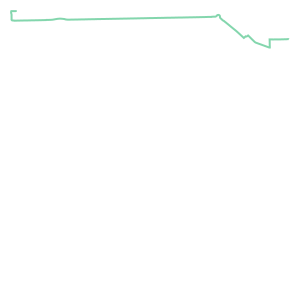

In [35]:
route_geo

In [36]:
trip_pt = one_trip.geometry.iloc[0]

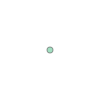

In [37]:
trip_pt

In [38]:
route_geo.project(trip_pt)

74.93606858573466

In [39]:
## convert times to DTs...

In [40]:
trip_pt2 = one_trip.geometry.iloc[1]

In [41]:
dist = route_geo.project(trip_pt2) - route_geo.project(trip_pt)

In [42]:
td = one_trip.vehicle_timestamp.iloc[1] - one_trip.vehicle_timestamp.iloc[0]

In [43]:
MPH_PER_MPS = 2.237

In [44]:
mps = dist / td.seconds ## meters/second

In [45]:
mps * MPH_PER_MPS ## a believable value for transit!

12.892640971929948

In [46]:
trip_st = (tbl.gtfs_schedule.stop_times()
     >> filter(_.calitp_itp_id == 170)
     >> filter(_.trip_id == '9288623')
     >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
     >> arrange(_.stop_sequence)
     >> collect()
    )

In [47]:
## stop times canonical; interpolate positions to hit
## geocode stops, linear reference

In [48]:
trip_st.head(3)

,calitp_itp_id,calitp_url_number,trip_id,stop_id,stop_sequence,arrival_time,departure_time,stop_headsign,pickup_type,drop_off_type,continuous_pickup,continuous_drop_off,shape_dist_traveled,timepoint,calitp_extracted_at
0,170,0,9288623,1026,1,16:56:00,16:56:00,None,0,0,None,None,0.0,1,2021-12-17
1,170,0,9288623,1027,2,16:58:10,16:58:10,None,0,0,None,None,0.311,0,2021-12-17
2,170,0,9288623,0540,3,17:00:17,17:00:17,None,0,0,None,None,0.616,0,2021-12-17


In [49]:
class VehiclePositionsTrip:
    '''Trip data and useful methods for analyzing GTFS-RT vehicle positions data'''
    
    def attach_shape(self, shape_gdf):
        assert shape_gdf.crs == shared_utils.geography_utils.CA_NAD83Albers
        assert shape_gdf.calitp_itp_id.iloc[0] == self.calitp_itp_id
        
        self.shapes = (shape_gdf
                        >> filter(_.shape_id == self.shape_id)
                        >> select(_.shape_id, _.geometry))
        self.linear_reference()
    
    def __init__(self, vp_gdf, shape_gdf):
        assert vp_gdf.crs == shared_utils.geography_utils.CA_NAD83Albers
        vp_gdf = vp_gdf >> distinct(_.trip_id, _.vehicle_timestamp, _keep_all=True)
        
        self.date = vp_gdf.date.iloc[0]
        self.trip_id = vp_gdf.trip_id.iloc[0]
        self.route_id = vp_gdf.route_id.iloc[0]
        self.shape_id = vp_gdf.shape_id.iloc[0]
        self.entity_id = vp_gdf.entity_id.iloc[0]
        self.vehicle_id = vp_gdf.vehicle_id.iloc[0]
        self.calitp_itp_id = vp_gdf.calitp_itp_id.iloc[0]
        self.calitp_url_number = vp_gdf.calitp_url_number.iloc[0]
        self.vehicle_positions = vp_gdf >> select(_.vehicle_timestamp,
                                              _.header_timestamp,
                                              _.geometry)
        self.attach_shape(shape_gdf)
        
    def linear_reference(self):
        self.vehicle_positions['shape_meters'] = (self.vehicle_positions.geometry
                                        .apply(lambda x: self.shapes.geometry.iloc[0].project(x)))
        self.vehicle_positions['last_time'] = self.vehicle_positions.vehicle_timestamp.shift(1)
        self.vehicle_positions['last_loc'] = self.vehicle_positions.shape_meters.shift(1)
        self.vehicle_positions['secs_from_last'] = self.vehicle_positions.vehicle_timestamp - self.vehicle_positions.last_time
        self.vehicle_positions.secs_from_last = (self.vehicle_positions.secs_from_last
                                        .apply(lambda x: x.seconds))
        self.vehicle_positions['meters_from_last'] = (self.vehicle_positions.shape_meters
                                                      - self.vehicle_positions.last_loc)
        self.vehicle_positions['speed_from_last'] = (self.vehicle_positions.meters_from_last
                                                     / self.vehicle_positions.secs_from_last)
    

        
#     def position_at_time(self, dt):
        
    def time_at_position(self, desired_position):
        
        try:
            next_point = (self.vehicle_positions
                  >> filter(_.shape_meters > desired_position)
                  >> filter(_.shape_meters == _.shape_meters.min())
                 )
            bounding_points = gdf.loc[next_point.index - 1].append(next_point)
            meters_to_next = bounding_points.iloc[-1].shape_meters - desired_position
            seconds_to_next = meters_to_next / bounding_points.iloc[-1].speed_from_last
            td_to_next = dt.timedelta(seconds=seconds_to_next)
            est_dt = bounding_points.iloc[-1].vehicle_timestamp - td_to_next

            return est_dt
        except:
            return None

In [50]:
test1 = VehiclePositionsTrip(one_trip, lbt_routelines)

In [51]:
gdf = test1.vehicle_positions

In [52]:
gdf.head(3)

,vehicle_timestamp,header_timestamp,geometry,shape_meters,last_time,last_loc,secs_from_last,meters_from_last,speed_from_last
0,2021-11-30 17:02:12,2021-11-30 17:02:37,POINT (174550.467 -468602.675),74.936069,NaT,NaN,NaN,NaN,NaN
1,2021-11-30 17:03:13,2021-11-30 17:03:37,POINT (174199.373 -468606.652),426.501155,2021-11-30 17:02:12,74.936069,61.0,351.565087,5.763362
2,2021-11-30 17:04:13,2021-11-30 17:04:37,POINT (173950.148 -468607.933),676.459161,2021-11-30 17:03:13,426.501155,60.0,249.958006,4.165967


In [53]:
test1.time_at_position(500)

Timestamp('2021-11-30 17:03:30.642686')

In [54]:
trip_st.head(2)

,calitp_itp_id,calitp_url_number,trip_id,stop_id,stop_sequence,arrival_time,departure_time,stop_headsign,pickup_type,drop_off_type,continuous_pickup,continuous_drop_off,shape_dist_traveled,timepoint,calitp_extracted_at
0,170,0,9288623,1026,1,16:56:00,16:56:00,None,0,0,None,None,0.0,1,2021-12-17
1,170,0,9288623,1027,2,16:58:10,16:58:10,None,0,0,None,None,0.311,0,2021-12-17


In [55]:
st = (tbl.gtfs_schedule.stop_times()
     >> filter(_.calitp_itp_id == 170)
     # >> filter(_.trip_id == '9288623')
     >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
     >> arrange(_.stop_sequence)
     >> collect()
    )

In [ ]:
stops = (tbl.gtfs_schedule.stops()
     >> filter(_.calitp_itp_id == 170)
     # >> filter(_.trip_id == '9288623')
     # >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
     # >> arrange(_.stop_sequence)
     >> select(_.calitp_itp_id, _.calitp_url_number, _.stop_id,
              _.stop_lat, _.stop_lon, _.stop_name)
     >> collect()
    )

In [ ]:
stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
                        crs='EPSG:4326').to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [ ]:
def delay_view(trip_id, trips_positions_joined, stop_times, stops, shape_gdf):
    global _debug
    global trip_rt_data
    
    this_trip = trips_positions_joined >> filter(_.trip_id == trip_id)
    trip_rt_data = VehiclePositionsTrip(this_trip, shape_gdf)
    
    trip_st = stop_times >> filter(_.trip_id == trip_id)
    trip_st_geo = stops >> inner_join(_, trip_st, on = ['calitp_itp_id', 'calitp_url_number',
                                     'stop_id'])
    trip_st_geo['linear_meters'] = (trip_st_geo.geometry
                                        .apply(lambda x: route_geo.project(x)))
    trip_st_geo['actual_time'] = trip_st_geo['linear_meters'].apply(lambda x: trip_rt_data.time_at_position(x))
    _debug = trip_st_geo
    trip_st_geo['arrival_time'] = trip_st_geo.arrival_time.apply(lambda x:
                                    dt.datetime.combine(trip_st_geo.actual_time.iloc[0].date(),
                                                        dt.datetime.strptime(x, '%H:%M:%S').time()))
    trip_st_geo['delay'] = trip_st_geo.actual_time - trip_st_geo.arrival_time
    trip_st_geo['date'] = trip_rt_data.date
    trip_view = trip_st_geo.dropna(subset=['delay']) >> arrange(_.arrival_time) >> select(
                                                    _.arrival_time, _.actual_time, _.delay,
                                                 _.stop_id, _.trip_id, _.stop_sequence,
                                            _.date, _.geometry)
    return trip_view

In [ ]:
delay_view('9288623', trips_positions_joined, st, stops, lbt_routelines)

,arrival_time,actual_time,delay,stop_id,trip_id,stop_sequence,date,geometry
23,2021-11-30 16:58:10,2021-11-30 17:03:30.892511,0 days 00:05:20.892511,1027,9288623,2,2021-12-01,POINT (174124.462 -468604.478)
12,2021-11-30 17:00:17,2021-11-30 17:05:15.130531,0 days 00:04:58.130531,0540,9288623,3,2021-12-01,POINT (173921.407 -468897.107)
19,2021-11-30 17:03:12,2021-11-30 17:06:36.379293,0 days 00:03:24.379293,0542,9288623,4,2021-12-01,POINT (173328.363 -468647.513)
15,2021-11-30 17:04:27,2021-11-30 17:07:16.572181,0 days 00:02:49.572181,0543,9288623,5,2021-12-01,POINT (173108.288 -468477.715)
26,2021-11-30 17:05:00,2021-11-30 17:07:32.964127,0 days 00:02:32.964127,0544,9288623,6,2021-12-01,POINT (173001.551 -468534.279)
28,2021-11-30 17:06:15,2021-11-30 17:08:53.462929,0 days 00:02:38.462929,4054,9288623,7,2021-12-01,POINT (172801.703 -468384.262)
16,2021-11-30 17:07:23,2021-11-30 17:09:53.361592,0 days 00:02:30.361592,4055,9288623,8,2021-12-01,POINT (172606.266 -468217.848)
21,2021-11-30 17:09:00,2021-11-30 17:11:29.070772,0 days 00:02:29.070772,1346,9288623,9,2021-12-01,POINT (172322.827 -467985.831)
9,2021-11-30 17:11:31,2021-11-30 17:19:58.390801,0 days 00:08:27.390801,1682,9288623,10,2021-12-01,POINT (171708.840 -467787.228)
4,2021-11-30 17:13:20,2021-11-30 17:21:38.738427,0 days 00:08:18.738427,1683,9288623,11,2021-12-01,POINT (171157.797 -467798.209)


In [ ]:
# _debug

In [ ]:
example_trips = (trips_positions_joined
 >> filter(_.route_id == '175', _.direction_id == '0') ## towards Villages at Cabrillo
 >> group_by(_.trip_id)
 >> summarize(max_time = _.vehicle_timestamp.max())
 >> arrange(_.max_time)
)
example_trips.head(6)

,trip_id,max_time
8,9288619,2021-11-30 16:37:23
9,9288621,2021-11-30 17:17:58
10,9288623,2021-11-30 17:56:04
11,9288625,2021-11-30 18:35:49
12,9288627,2021-11-30 19:24:12
13,9288629,2021-11-30 19:59:08


In [ ]:
example_trips.trip_id.iloc[:6]

8     9288619
9     9288621
10    9288623
11    9288625
12    9288627
13    9288629
Name: trip_id, dtype: object

In [63]:
delays = gpd.GeoDataFrame()

for trip_id in example_trips.trip_id.iloc[:6]:
    
    single_trip_delay = delay_view(trip_id, trips_positions_joined, st, stops, lbt_routelines)
    delays = delays.append(single_trip_delay)

In [64]:
delays

,arrival_time,actual_time,delay,stop_id,trip_id,stop_sequence,date,geometry
19,2021-11-30 15:42:12,2021-11-30 16:00:17.489783,0 days 00:18:05.489783,0542,9288619,4,2021-12-01,POINT (173328.363 -468647.513)
15,2021-11-30 15:43:27,2021-11-30 16:01:08.496330,0 days 00:17:41.496330,0543,9288619,5,2021-12-01,POINT (173108.288 -468477.715)
26,2021-11-30 15:44:00,2021-11-30 16:01:37.389317,0 days 00:17:37.389317,0544,9288619,6,2021-12-01,POINT (173001.551 -468534.279)
28,2021-11-30 15:45:15,2021-11-30 16:03:06.190004,0 days 00:17:51.190004,4054,9288619,7,2021-12-01,POINT (172801.703 -468384.262)
16,2021-11-30 15:46:23,2021-11-30 16:03:44.801889,0 days 00:17:21.801889,4055,9288619,8,2021-12-01,POINT (172606.266 -468217.848)
...,...,...,...,...,...,...,...,...
14,2021-11-30 19:32:08,2021-11-30 19:33:19.123625,0 days 00:01:11.123625,0011,9288629,24,2021-12-01,POINT (166864.163 -467876.750)
8,2021-11-30 19:32:42,2021-11-30 19:33:50.098569,0 days 00:01:08.098569,0012,9288629,25,2021-12-01,POINT (166631.631 -467882.275)
17,2021-11-30 19:35:01,2021-11-30 20:00:12.709222,0 days 00:25:11.709222,3140,9288629,26,2021-12-01,POINT (165660.454 -467899.210)
10,2021-11-30 19:36:00,2021-11-30 19:37:09.103320,0 days 00:01:09.103320,3048,9288629,27,2021-12-01,POINT (165247.302 -467911.875)


In [65]:
delays >> group_by(_.stop_id) >> summarize(avg_delay = _.delay.mean()) >> inner_join(_, delays, on = 'stop_id')

,stop_id,avg_delay,arrival_time,actual_time,delay,trip_id,stop_sequence,date,geometry
0,0008,0 days 00:06:51.129001,2021-11-30 16:05:38,2021-11-30 16:20:34.713014,0 days 00:14:56.713014,9288619,21,2021-12-01,POINT (167563.083 -467866.435)
1,0008,0 days 00:06:51.129001,2021-11-30 16:46:38,2021-11-30 17:00:29.372129,0 days 00:13:51.372129,9288621,21,2021-12-01,POINT (167563.083 -467866.435)
2,0008,0 days 00:06:51.129001,2021-11-30 17:25:38,2021-11-30 17:34:48.137547,0 days 00:09:10.137547,9288623,21,2021-12-01,POINT (167563.083 -467866.435)
3,0008,0 days 00:06:51.129001,2021-11-30 18:06:33,2021-11-30 18:10:33.866792,0 days 00:04:00.866792,9288625,21,2021-12-01,POINT (167563.083 -467866.435)
4,0008,0 days 00:06:51.129001,2021-11-30 18:45:33,2021-11-30 18:44:38.327909,-1 days +23:59:05.327909,9288627,21,2021-12-01,POINT (167563.083 -467866.435)
...,...,...,...,...,...,...,...,...,...
154,4055,0 days 00:06:40.507626666,2021-11-30 16:27:23,2021-11-30 16:44:51.168044,0 days 00:17:28.168044,9288621,8,2021-12-01,POINT (172606.266 -468217.848)
155,4055,0 days 00:06:40.507626666,2021-11-30 17:07:23,2021-11-30 17:09:53.361592,0 days 00:02:30.361592,9288623,8,2021-12-01,POINT (172606.266 -468217.848)
156,4055,0 days 00:06:40.507626666,2021-11-30 17:48:23,2021-11-30 17:50:04.729044,0 days 00:01:41.729044,9288625,8,2021-12-01,POINT (172606.266 -468217.848)
157,4055,0 days 00:06:40.507626666,2021-11-30 18:28:23,2021-11-30 18:28:50.310258,0 days 00:00:27.310258,9288627,8,2021-12-01,POINT (172606.266 -468217.848)


In [66]:
# example_trip = delays >> filter(_.trip_id == '9288621')
example_trip = delay_view('9288623', trips_positions_joined, st, stops, lbt_routelines)
example_trip['delay_minutes'] = example_trip.delay.apply(lambda x: round((x.seconds / 60), 0))

In [67]:
example_trip >> arrange(_.stop_sequence)

,arrival_time,actual_time,delay,stop_id,trip_id,stop_sequence,date,geometry,delay_minutes
23,2021-11-30 16:58:10,2021-11-30 17:03:30.892511,0 days 00:05:20.892511,1027,9288623,2,2021-12-01,POINT (174124.462 -468604.478),5.0
12,2021-11-30 17:00:17,2021-11-30 17:05:15.130531,0 days 00:04:58.130531,0540,9288623,3,2021-12-01,POINT (173921.407 -468897.107),5.0
19,2021-11-30 17:03:12,2021-11-30 17:06:36.379293,0 days 00:03:24.379293,0542,9288623,4,2021-12-01,POINT (173328.363 -468647.513),3.0
15,2021-11-30 17:04:27,2021-11-30 17:07:16.572181,0 days 00:02:49.572181,0543,9288623,5,2021-12-01,POINT (173108.288 -468477.715),3.0
26,2021-11-30 17:05:00,2021-11-30 17:07:32.964127,0 days 00:02:32.964127,0544,9288623,6,2021-12-01,POINT (173001.551 -468534.279),3.0
28,2021-11-30 17:06:15,2021-11-30 17:08:53.462929,0 days 00:02:38.462929,4054,9288623,7,2021-12-01,POINT (172801.703 -468384.262),3.0
16,2021-11-30 17:07:23,2021-11-30 17:09:53.361592,0 days 00:02:30.361592,4055,9288623,8,2021-12-01,POINT (172606.266 -468217.848),2.0
21,2021-11-30 17:09:00,2021-11-30 17:11:29.070772,0 days 00:02:29.070772,1346,9288623,9,2021-12-01,POINT (172322.827 -467985.831),2.0
9,2021-11-30 17:11:31,2021-11-30 17:19:58.390801,0 days 00:08:27.390801,1682,9288623,10,2021-12-01,POINT (171708.840 -467787.228),8.0
4,2021-11-30 17:13:20,2021-11-30 17:21:38.738427,0 days 00:08:18.738427,1683,9288623,11,2021-12-01,POINT (171157.797 -467798.209),8.0


In [68]:
simple_map(example_trip >> select(_.geometry, _.delay_minutes), 'delay_minutes')

Map(center=[33.782130000228925, -118.12028799999996], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [73]:
test1.trip_id

'9288623'

In [72]:
test1.vehicle_positions

,vehicle_timestamp,header_timestamp,geometry,shape_meters,last_time,last_loc,secs_from_last,meters_from_last,speed_from_last
0,2021-11-30 17:02:12,2021-11-30 17:02:37,POINT (174550.467 -468602.675),74.936069,NaT,NaN,NaN,NaN,NaN
1,2021-11-30 17:03:13,2021-11-30 17:03:37,POINT (174199.373 -468606.652),426.501155,2021-11-30 17:02:12,74.936069,61.0,351.565087,5.763362
2,2021-11-30 17:04:13,2021-11-30 17:04:37,POINT (173950.148 -468607.933),676.459161,2021-11-30 17:03:13,426.501155,60.0,249.958006,4.165967
3,2021-11-30 17:05:13,2021-11-30 17:05:37,POINT (173918.072 -468878.428),972.368106,2021-11-30 17:04:13,676.459161,60.0,295.908945,4.931816
4,2021-11-30 17:06:13,2021-11-30 17:06:37,POINT (173459.833 -468740.749),1500.157208,2021-11-30 17:05:13,972.368106,60.0,527.789102,8.796485
5,2021-11-30 17:07:13,2021-11-30 17:07:37,POINT (173140.325 -468467.212),1926.804568,2021-11-30 17:06:13,1500.157208,60.0,426.647360,7.110789
6,2021-11-30 17:07:52,2021-11-30 17:08:07,POINT (172896.465 -468477.119),2234.057989,2021-11-30 17:07:13,1926.804568,39.0,307.253421,7.878293
7,2021-11-30 17:08:52,2021-11-30 17:09:07,POINT (172806.146 -468388.722),2360.319473,2021-11-30 17:07:52,2234.057989,60.0,126.261483,2.104358
8,2021-11-30 17:09:53,2021-11-30 17:10:07,POINT (172608.224 -468218.475),2621.209294,2021-11-30 17:08:52,2360.319473,61.0,260.889822,4.276882
9,2021-11-30 17:10:53,2021-11-30 17:11:07,POINT (172354.087 -468016.053),2946.072428,2021-11-30 17:09:53,2621.209294,60.0,324.863133,5.414386


In [69]:
## a good view: trip, (direction), stop, timedelta?
## plot deltas with a sequential scheme...